# Préparation et Chargement des données 

## 1. Importation des bibliothèques

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score
from sklearn.linear_model import Perceptron, LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.impute import SimpleImputer

## 2. Chargement des datasets 

In [44]:
t_arr = pd.read_csv("in_time.csv")
t_dép = pd.read_csv("out_time.csv")
emp_survey = pd.read_csv("employee_survey_data.csv")
gen_data = pd.read_csv("general_data.csv")
man_survey = pd.read_csv("manager_survey_data.csv")      

## 3. Gestion des valeurs manquantes

### 3.1 Taux de valeurs manquantes

In [45]:
missing_rates = t_arr.isna().mean()
print(missing_rates)

Unnamed: 0    0.000000
2015-01-01    1.000000
2015-01-02    0.047392
2015-01-05    0.046712
2015-01-06    0.051701
                ...   
2015-12-25    1.000000
2015-12-28    0.053061
2015-12-29    0.052154
2015-12-30    0.060091
2015-12-31    0.048299
Length: 262, dtype: float64


In [5]:
missing_rates = t_dép.isnull().mean()
print(missing_rates)

Unnamed: 0    0.000000
2015-01-01    1.000000
2015-01-02    0.047392
2015-01-05    0.046712
2015-01-06    0.051701
                ...   
2015-12-25    1.000000
2015-12-28    0.053061
2015-12-29    0.052154
2015-12-30    0.060091
2015-12-31    0.048299
Length: 262, dtype: float64


### 3.2 Nettoyage des données

#### Fonction utilisée pour convertir les durées en minutes

In [6]:
# Fonction pour convertir datetime.time en secondes depuis minuit
def time_to_minutes(time_obj):
    """Convertit un objet datetime.time en secondes depuis minuit."""
    if time_obj is not pd.NaT:  # Vérifie si la valeur n'est pas NaN
        return time_obj.hour * 60 + time_obj.minute * 60 + time_obj.second/60
    return None

#### 3.2.1 Nettoyage du dataset des temps d'arrivée

In [7]:
threshold = 0.9
column_to_drop = missing_rates[missing_rates>= threshold].index
t_arr_cleaned = t_arr.drop(columns=column_to_drop)
t_arr_cleaned = t_arr_cleaned.drop(columns="Unnamed: 0")
t_arr_cleaned.shape

(4410, 249)

In [ ]:
# conversion en date time 
t_arr_cleaned.columns = pd.to_datetime(t_arr_cleaned.columns)
t_arr_converted = t_arr_cleaned.apply(pd.to_datetime)
t_arr_converted = t_arr_converted.apply(lambda col: col.dt.time)

# Appliquer la conversion en secondes sur votre DataFrame
t_arr_seconds = t_arr_converted.applymap(lambda x: time_to_minutes(x))
# Calculer la médiane des secondes pour chaque colonne
medians = t_arr_seconds.median()
# Remplacer les valeurs manquantes par la médiane en secondes
t_arr_seconds_filled = t_arr_seconds.apply(lambda col: col.fillna(medians[col.name]))
# Afficher le DataFrame final avec les valeurs manquantes remplies
t_arr_seconds_filled


####  3.2.2 Nettoyage du dataset des temps de départ

In [9]:
t_dép_cleaned = t_dép.drop(columns= column_to_drop)
t_dép_cleaned = t_dép_cleaned.drop(columns="Unnamed: 0")
t_dép_cleaned.shape

(4410, 249)

In [ ]:
# conversion en date time 
t_dép_cleaned.columns = pd.to_datetime(t_dép_cleaned.columns)
t_dép_converted = t_dép_cleaned.apply(pd.to_datetime)
t_dép_converted = t_dép_converted.apply(lambda col: col.dt.time)

# Appliquer la conversion en secondes sur votre DataFrame
t_dép_seconds = t_dép_converted.applymap(lambda x: time_to_minutes(x))
# Calculer la médiane des secondes pour chaque colonne
medians = t_dép_seconds.median()
# Remplacer les valeurs manquantes par la médiane en secondes
t_dép_seconds_filled = t_dép_seconds.apply(lambda col: col.fillna(medians[col.name]))
# Afficher le DataFrame final avec les valeurs manquantes remplies
t_dép_seconds_filled

#### 3.2.3 Dataset de durée moyenne de travail de chaque employé 

In [28]:
t_durée = t_dép_seconds_filled - t_arr_seconds_filled
t_durée_mean= t_durée.mean(axis=1)
t_durée_mean = t_durée_mean.to_frame(name="worktime_mean")
t_durée_mean.head()

,worktime_mean
0,326.958434
1,369.942303
2,525.524264
3,353.988788
4,345.297523


#### 3.2.4 Nettoyage du dataset des enquêtes sur les employés

In [43]:
emp_survey = emp_survey.fillna(emp_survey.median())
emp_survey.isna().mean()

EmployeeID                 0.0
EnvironmentSatisfaction    0.0
JobSatisfaction            0.0
WorkLifeBalance            0.0
dtype: float64

#### 3.3 Concatenation du dataset résultant « t_durée » avec gen_data et les data-set surveys

In [41]:
result = pd.concat([gen_data, man_survey, emp_survey,t_durée_mean], axis=1)
result_final = result.loc[:, ~result.columns.duplicated()]
result_final.head()

,Age,Attrition,BusinessTravel,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeID,Gender,...,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager,JobInvolvement,PerformanceRating,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,worktime_mean
0,51,No,Travel_Rarely,Sales,6,2,Life Sciences,1,1,Female,...,6,1,0,0,3,3,3.0,4.0,2.0,326.958434
1,31,Yes,Travel_Frequently,Research & Development,10,1,Life Sciences,1,2,Female,...,3,5,1,4,2,4,3.0,2.0,4.0,369.942303
2,32,No,Travel_Frequently,Research & Development,17,4,Other,1,3,Male,...,2,5,0,3,3,3,2.0,2.0,1.0,525.524264
3,38,No,Non-Travel,Research & Development,2,5,Life Sciences,1,4,Male,...,5,8,7,5,2,3,4.0,4.0,3.0,353.988788
4,32,No,Travel_Rarely,Research & Development,10,1,Medical,1,5,Male,...,2,6,0,4,3,3,4.0,1.0,3.0,345.297523


#### 3.4 Encodage et Normalisation des données

##### 3.4.1 Encodage des données

In [46]:
result_final_cat = result_final.select_dtypes(include=[object])
encoder = OneHotEncoder(sparse_output=False)
result_final_cat_prepared = encoder.fit_transform(result_final_cat)
result_final_encoded = pd.DataFrame(result_final_cat_prepared, columns=encoder.get_feature_names_out(input_features=result_final_cat.columns))
result_final_encoded.head()

,Attrition_No,Attrition_Yes,BusinessTravel_Non-Travel,BusinessTravel_Travel_Frequently,BusinessTravel_Travel_Rarely,Department_Human Resources,Department_Research & Development,Department_Sales,EducationField_Human Resources,EducationField_Life Sciences,...,JobRole_Manager,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single,Over18_Y
0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
1,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0
2,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
3,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
4,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0


##### 3.4.2 Normalisation des données 

In [47]:
imputer = SimpleImputer(strategy="median")
result_final_num = result_final.select_dtypes(include=['number'])
scaler = StandardScaler()
result_final_scaled = pd.DataFrame(scaler.fit_transform(result_final_num), columns=result_final_num.columns)
result_final_scaled.head()

,Age,DistanceFromHome,Education,EmployeeCount,EmployeeID,JobLevel,MonthlyIncome,NumCompaniesWorked,PercentSalaryHike,StandardHours,...,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager,JobInvolvement,PerformanceRating,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,worktime_mean
0,1.541369,-0.393938,-0.891688,0.0,-1.731658,-0.961486,1.405136,-0.678311,-1.150554,0.0,...,2.483396,-0.981014,-0.679146,-1.155935,0.379672,-0.426230,0.252200,1.156302,-1.085336,-1.067289
1,-0.648668,0.099639,-1.868426,0.0,-1.730873,-0.961486,-0.491661,-1.078535,2.129306,0.0,...,0.155707,-0.327893,-0.368715,-0.034520,-1.026167,2.346151,0.252200,-0.663899,1.757749,-0.730393
2,-0.539166,0.963398,1.061787,0.0,-1.730087,1.749610,2.725053,-0.678311,-0.057267,0.0,...,-0.620189,-0.327893,-0.679146,-0.314873,0.379672,-0.426230,-0.665460,-0.663899,-2.506879,0.489015
3,0.117845,-0.887515,2.038524,0.0,-1.729302,0.845911,0.386301,0.122136,-1.150554,0.0,...,1.707500,0.161947,1.493867,0.245834,-1.026167,-0.426230,1.169861,1.156302,0.336206,-0.855432
4,-0.539166,0.099639,-1.868426,0.0,-1.728516,-0.961486,-0.884109,0.522360,-0.877232,0.0,...,-0.620189,-0.164613,-0.679146,-0.034520,0.379672,-0.426230,1.169861,-1.573999,0.336206,-0.923552


##### 3.4.3 Dataset final normalisé et encodé 

In [48]:
finalresult = pd.concat([result_final_encoded,result_final_scaled], axis=1)
finalresult.head()

,Attrition_No,Attrition_Yes,BusinessTravel_Non-Travel,BusinessTravel_Travel_Frequently,BusinessTravel_Travel_Rarely,Department_Human Resources,Department_Research & Development,Department_Sales,EducationField_Human Resources,EducationField_Life Sciences,...,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager,JobInvolvement,PerformanceRating,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,worktime_mean
0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,...,2.483396,-0.981014,-0.679146,-1.155935,0.379672,-0.426230,0.252200,1.156302,-1.085336,-1.067289
1,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.155707,-0.327893,-0.368715,-0.034520,-1.026167,2.346151,0.252200,-0.663899,1.757749,-0.730393
2,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,-0.620189,-0.327893,-0.679146,-0.314873,0.379672,-0.426230,-0.665460,-0.663899,-2.506879,0.489015
3,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,1.707500,0.161947,1.493867,0.245834,-1.026167,-0.426230,1.169861,1.156302,0.336206,-0.855432
4,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,-0.620189,-0.164613,-0.679146,-0.034520,0.379672,-0.426230,1.169861,-1.573999,0.336206,-0.923552


# Exploration et Visualisation des données 

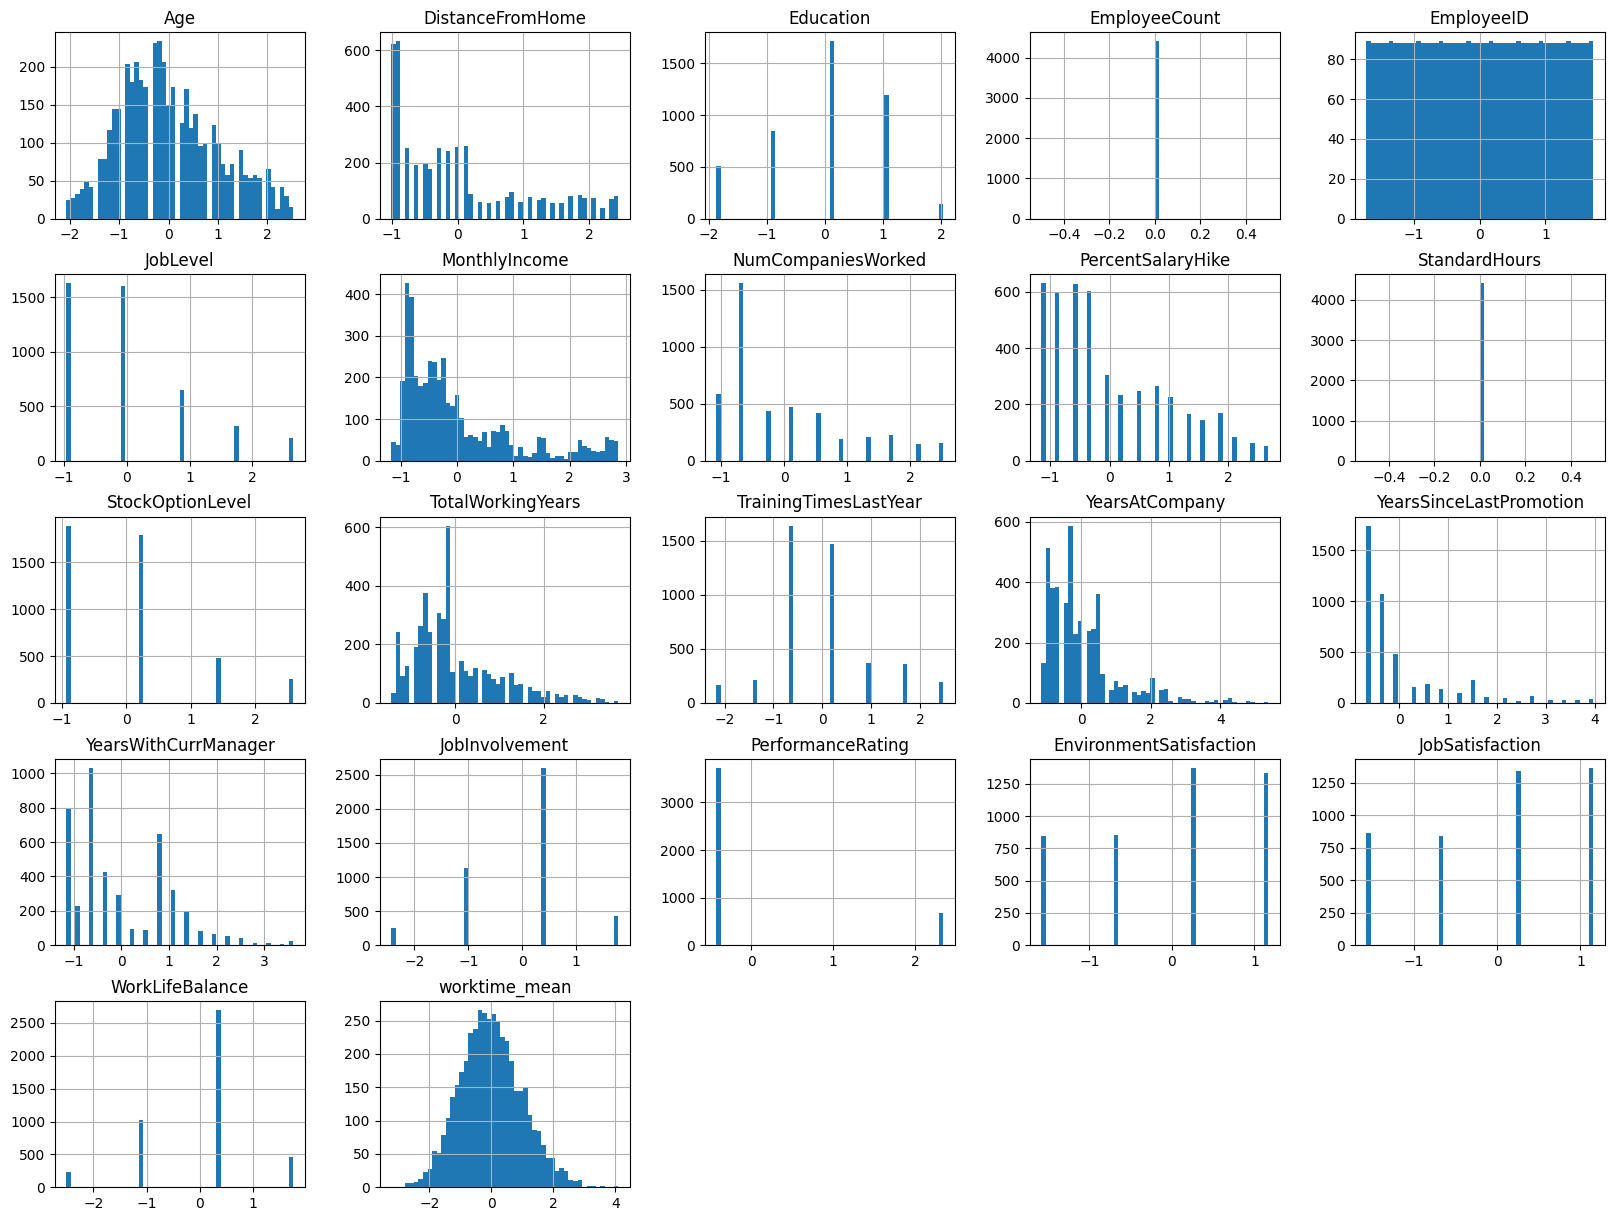

In [49]:
result_final_scaled.hist(bins=50, figsize=(20,15))
plt.show()